## Drought variables across CMIP6 
Research Computing for Earth Sciences Final Project <br>
December 2020 <br>
Miriam Nielsen

### Research Question
What is the relationship between drought-associated variables across CMIP6 Historical Model Experiments?



In [56]:
# Needed Packages
import cartopy.crs as ccrs
import cartopy
import zarr
import fsspec
import intake
import regionmask

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
xr.set_options(display_style='html')

import dask
import dask.array as da

from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')


In [37]:
import warnings
warnings.filterwarnings("ignore")

# Silence dask.distributed logs
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)
import dask.config
dask.config.set({'distributed.logging.distributed': 'error'})

### Create Dask Cluster

In [57]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=20)
client = Client(cluster)
cluster

### Data Loading & Organizing

In [59]:
# open pangeo catalogue of CMIP6 experiments
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

# open using intake
col = intake.open_esm_datastore(cat_url)
print(col) #Summary of collection structure
col

<pangeo-cmip6 catalog with 5854 dataset(s) from 352731 asset(s)>


,unique
activity_id,17
institution_id,35
source_id,80
experiment_id,150
member_id,506
table_id,36
variable_id,666
grid_label,10
zstore,352731
dcpp_init_year,60


In [65]:
print(df['experiment_id'].unique())
# print(df['source_id'].unique())

['histSST' 'piClim-CH4' 'piClim-NTCF' 'piClim-control' 'ssp370'
 'hist-1950HC' 'piClim-2xDMS' 'piClim-2xdust' 'piClim-2xfire'
 'piClim-2xss' 'piClim-BC' 'piClim-HC' 'piClim-N2O' 'piClim-OC'
 'piClim-SO2' 'piClim-aer' 'hist-piNTCF' 'hist-piAer' 'histSST-1950HC'
 'histSST-piAer' 'histSST-piCH4' 'histSST-piNTCF' 'histSST-piO3'
 'piClim-2xNOx' 'piClim-2xVOC' 'piClim-NOx' 'piClim-O3' 'piClim-VOC'
 'ssp370-lowNTCF' 'ssp370SST-lowCH4' 'ssp370SST-lowNTCF'
 'ssp370SST-ssp126Lu' 'ssp370SST' 'ssp370pdSST' '1pctCO2-bgc'
 '1pctCO2-rad' 'esm-ssp585' 'hist-bgc' '1pctCO2-cdr' 'esm-pi-CO2pulse'
 'esm-pi-cdr-pulse' 'amip-4xCO2' 'amip-future4K' 'amip-m4K' 'amip-p4K'
 'amip' 'abrupt-2xCO2' 'abrupt-solp4p' 'abrupt-0p5xCO2' 'amip-lwoff'
 'amip-p4K-lwoff' 'aqua-4xCO2' 'abrupt-solm4p' 'aqua-control-lwoff'
 'aqua-control' 'aqua-p4K-lwoff' 'aqua-p4K' '1pctCO2' 'abrupt-4xCO2'
 'historical' 'piControl' 'esm-hist' 'esm-piControl' 'ssp126' 'ssp245'
 'ssp585' 'amip-hist' 'esm-piControl-spinup' 'piControl-spinup' 'hi

In [74]:
query = dict(
    # WHICH EXPERIMENTS SHOULD I USE??? 
    # options: 'historical', 'ssp245', 'ssp585' <- lots for tas, idk about other variables
    
    experiment_id=['abrupt-4xCO2','piControl'], # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    variable_id=['tas', 'tasmax','mrsos'],      # near-surface air temperature (tas), maximum surface air temperature (tasmax), and surface soil moisture (mrsos)
    # WHICH REALIZATION SHOULD I USE?? 
    member_id = 'r1i1p1f1',                     # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()


,experiment_id,variable_id,table_id
source_id,,,
BCC-CSM2-MR,2,3,2
BCC-ESM1,2,3,2
CanESM5,2,3,3
GFDL-CM4,2,3,4
GFDL-ESM4,2,3,4
GISS-E2-1-G,2,3,2
GISS-E2-1-H,2,3,2
IPSL-CM6A-LR,2,3,3
MIROC6,2,3,3


In [76]:
def drop_all_bounds(ds):
    """Drop coordinates like 'time_bounds' from datasets,
    which can lead to issues when merging."""
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dsets(df):
    """Open datasets from cloud storage and return xarray dataset."""
    dsets = [xr.open_zarr(fsspec.get_mapper(ds_url), consolidated=True)
             .pipe(drop_all_bounds)
             for ds_url in df.zstore]
    try:
        ds = xr.merge(dsets, join='exact')
        return ds
    except ValueError:
        return None

def open_delayed(df):
    """A dask.delayed wrapper around `open_dsets`.
    Allows us to open many datasets in parallel."""
    return dask.delayed(open_dsets)(df)



In [78]:
from collections import defaultdict

dsets = defaultdict(dict)
for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)
dsets

defaultdict(dict,
            {'BCC-CSM2-MR': {'abrupt-4xCO2': Delayed('open_dsets-797e779a-876f-47e8-91e6-0bca60cc3f5f'),
              'piControl': Delayed('open_dsets-c7d80bcd-1ef2-4a65-827a-dfa0b23537ac')},
             'BCC-ESM1': {'abrupt-4xCO2': Delayed('open_dsets-3beb44ae-784e-4f31-a258-159fd89e785c'),
              'piControl': Delayed('open_dsets-c8ccd5e4-f8af-47ae-9bb9-ee12aae0b839')},
             'CanESM5': {'abrupt-4xCO2': Delayed('open_dsets-6581f8dc-b134-4862-87b9-786f8a1cc456'),
              'piControl': Delayed('open_dsets-6730fe30-2867-42c6-b4c3-14d538a0fbd6')},
             'GFDL-CM4': {'abrupt-4xCO2': Delayed('open_dsets-5b67a242-e2d7-4ced-95bd-0c2509d5eb91'),
              'piControl': Delayed('open_dsets-bc45cb25-a7be-4879-ab74-bf1048985858')},
             'GFDL-ESM4': {'abrupt-4xCO2': Delayed('open_dsets-460a474b-0d19-4322-a686-ce7e462f9632'),
              'piControl': Delayed('open_dsets-345915cd-e39b-4cd7-ba4c-3535553cf839')},
             'GISS-E2-1-G': {

In [ ]:
dsets_ = dask.compute(dict(dsets))[0]

In [103]:
dsets_

{'BCC-CSM2-MR': {'abrupt-4xCO2': None, 'piControl': None},
 'BCC-ESM1': {'abrupt-4xCO2': None, 'piControl': None},
 'CanESM5': {'abrupt-4xCO2': <xarray.Dataset>
  Dimensions:  (lat: 64, lon: 128, time: 1812)
  Coordinates:
      height   float64 2.0
    * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
    * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    * time     (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
      depth    float64 ...
  Data variables:
      tas      (time, lat, lon) float32 dask.array<chunksize=(906, 64, 128), meta=np.ndarray>
      tasmax   (time, lat, lon) float32 dask.array<chunksize=(1812, 64, 128), meta=np.ndarray>
      mrsos    (time, lat, lon) float32 dask.array<chunksize=(1812, 64, 128), meta=np.ndarray>,
  'piControl': None},
 'GFDL-CM4': {'abrupt-4xCO2': None, 'piControl': None},
 'GFDL-ESM4': {'abrupt-4xCO2': None, 'piControl': None},
 'GISS-E2-1-G': {'abrupt-4xCO2': <xarray.Dataset>


### Global Mean Comparison
Reduce data with global mean, weighted by a factor proportional to cos(lat)

In [81]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [82]:
expts = ['piControl', 'abrupt-4xCO2']
expt_da = xr.DataArray(expts, dims='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year - ds.time.dt.year[0]

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='right',
                                 dim=expt_da)

Missing experiment for BCC-CSM2-MR
Missing experiment for BCC-ESM1
Missing experiment for CanESM5
Missing experiment for GFDL-CM4
Missing experiment for GFDL-ESM4
Missing experiment for IPSL-CM6A-LR
Missing experiment for MIROC6
Missing experiment for MRI-ESM2-0
Missing experiment for SAM0-UNICON



In [107]:
expt_da

<xarray.DataArray (experiment_id: 2)>
array(['piControl', 'abrupt-4xCO2'], dtype='<U12')
Coordinates:
  * experiment_id  (experiment_id) <U12 'piControl' 'abrupt-4xCO2'

In [106]:
dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [105]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                   dim=source_da)
big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 2, source_id: 2, year: 151)
Coordinates:
  * source_id      (source_id) object 'GISS-E2-1-G' 'GISS-E2-1-H'
  * experiment_id  (experiment_id) object 'piControl' 'abrupt-4xCO2'
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 147.0 148.0 149.0 150.0
Data variables:
    tas            (source_id, experiment_id, year) float64 286.9 ... 292.4
    tasmax         (source_id, experiment_id, year) float64 288.9 ... 294.2
    mrsos          (source_id, experiment_id, year) float64 5.669 ... 5.086
    None           (source_id) <U11 'GISS-E2-1-G' 'GISS-E2-1-H'

### TK SOME ANALYSIS

In [91]:
ds_mean = big_ds[['tas','tasmax','mrsos']].sel(experiment_id='piControl').mean(dim='year')
ds_anom = big_ds[['tas','tasmax','mrsos']] - ds_mean

# add some metadata
ds_anom.tas.attrs['long_name'] = 'Global Mean Surface Temp Anom'
ds_anom.tas.attrs['units'] = 'K'
ds_anom.tasmax.attrs['long_name'] = 'Global Mean Maximum Surface Temperature Anom'
ds_anom.tasmax.attrs['units'] = 'K'
ds_anom.mrsos.attrs['long_name'] = 'Global Mean Surface Soil Moisture Anom'
# figure out what units mrsos is in 

ds_anom

<xarray.Dataset>
Dimensions:        (experiment_id: 2, source_id: 2, year: 151)
Coordinates:
  * source_id      (source_id) object 'GISS-E2-1-G' 'GISS-E2-1-H'
  * experiment_id  (experiment_id) object 'piControl' 'abrupt-4xCO2'
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 147.0 148.0 149.0 150.0
Data variables:
    tas            (source_id, experiment_id, year) float64 0.02001 ... 5.139
    tasmax         (source_id, experiment_id, year) float64 0.007263 ... 4.978
    mrsos          (source_id, experiment_id, year) float64 -0.002003 ... -0....

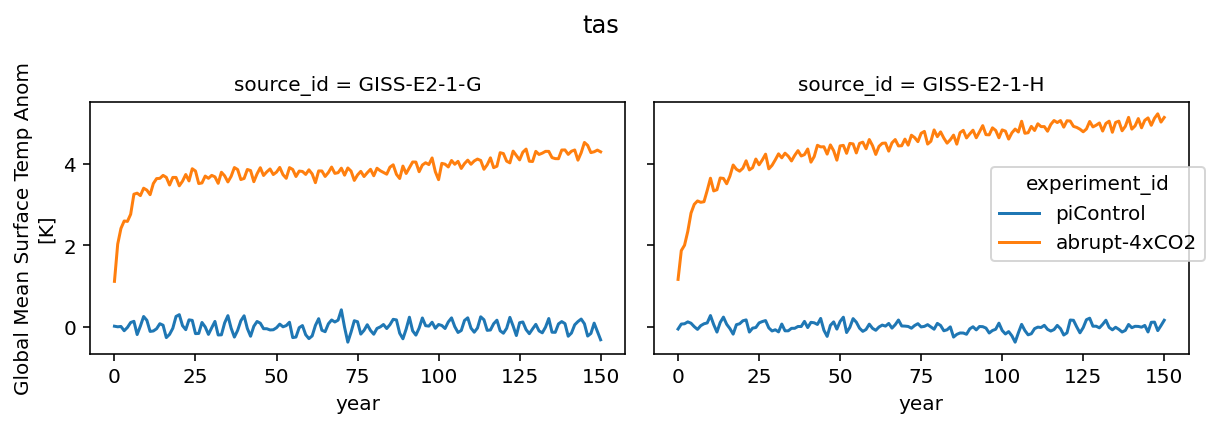

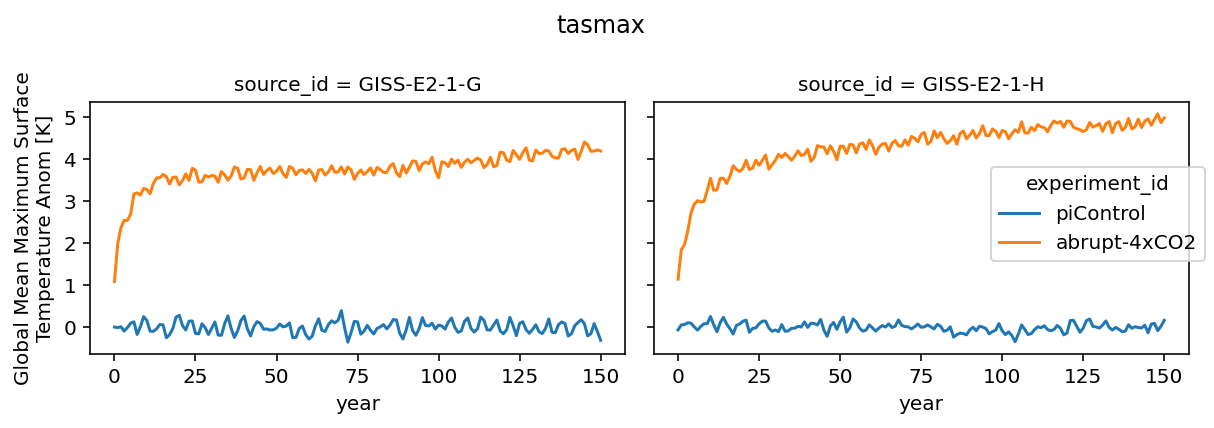

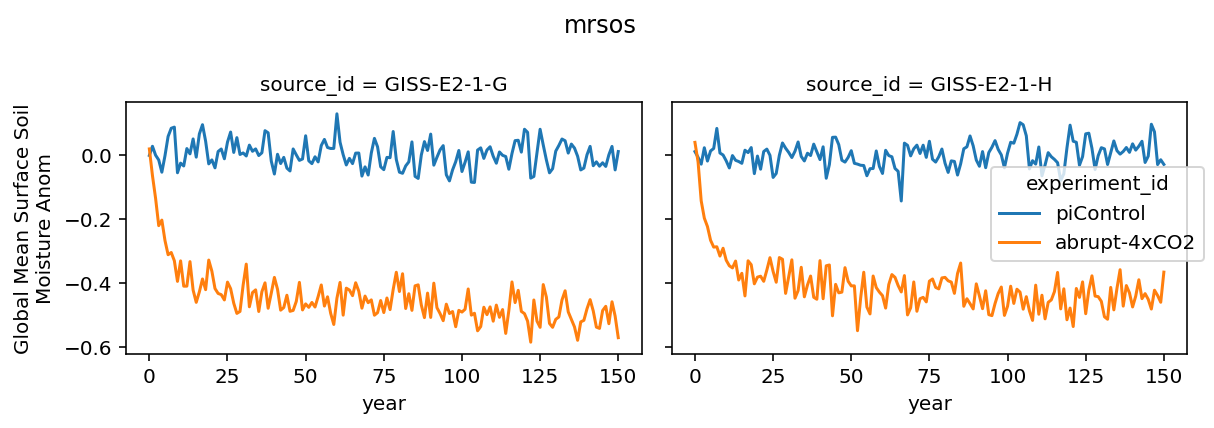

In [101]:
drought_vars = ['tas','tasmax','mrsos']

for i in drought_vars:
    ds_anom[i].plot.line(col='source_id', x='year', col_wrap = 2) # expand col_wrap with more experiments
    plt.suptitle(i)
    plt.tight_layout()

### correlation


In [ ]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))



In [ ]:
# Gracefully destroy/close our cluster
client.close()
cluster.close()

In [52]:
df_drought = df[(df.table_id == 'Lmon') & (df.variable_id == 'mrsos') & (df.activity_id == 'CMIP')]
len(df_drought)

535

In [53]:
run_counts = df_drought.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id      experiment_id
ACCESS-CM2     1pctCO2           1
               amip              3
               historical        2
               piControl         1
ACCESS-ESM1-5  1pctCO2           1
                                ..
UKESM1-0-LL    1pctCO2           4
               abrupt-4xCO2      1
               amip              1
               historical       13
               piControl         1
Name: zstore, Length: 149, dtype: int64

In [54]:
source_ids = []
experiment_ids = ['historical', 'ssp585']
for name, group in df_drought.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

[]

In [68]:
# open pangeo catalogue of CMIP6 experiments
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

# open using intake
col = intake.open_esm_datastore(cat_url)
print(col) #Summary of collection structure


# create a dictionary of source, experiment, and variable information for easy access later
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])

# Find all CMIP6 historical experiments that include all three variables of interest
models = set(uni_dict['source_id']['values']) # all the models

for variable_id in ['tas', 'tasmax', 'mrsos']:
    query = dict(experiment_id='historical', table_id=['Amon','Lmon'], 
                 variable_id=variable_id, activity_id ='CMIP')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)
print("Relevant historical experiments:", models)

<pangeo-cmip6 catalog with 5854 dataset(s) from 352731 asset(s)>
Relevant historical experiments: ['BCC-ESM1', 'UKESM1-0-LL', 'ACCESS-ESM1-5', 'MRI-ESM2-0', 'MIROC-ES2L', 'GFDL-CM4', 'CanESM5', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'GFDL-ESM4', 'BCC-CSM2-MR', 'GISS-E2-2-G', 'SAM0-UNICON', 'CanESM5-CanOE', 'MIROC6', 'CAS-ESM2-0', 'MPI-ESM-1-2-HAM', 'GISS-E2-1-H', 'GISS-E2-1-G-CC', 'CNRM-CM6-1', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'HadGEM3-GC31-LL', 'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'ACCESS-CM2', 'CMCC-CM2-SR5', 'KACE-1-0-G', 'EC-Earth3', 'GISS-E2-1-G']


In [34]:
# Create a catalogue of all relevant models 
#cat = col.search(experiment_id='historical', table_id=['Amon','Lmon'], 
#                 variable_id=['tas', 'tasmax', 'mrsos'], activity_id ='CMIP', source_id=models)
#cat.df

# create a catalogue of a smaller list of models 
cat = col.search(experiment_id = 'historical', table_id = ['Amon', 'Lmon'], 
                 variable_id = ['tas', 'tasmax', 'mrsos'], 
                 activity_id = 'CMIP', 
                 source_id = ['GFDL-CM4', 'GISS-E2-1-H', 'GISS-E2-1-G'])

In [35]:
# avoid creating the large chunks when creating a dictionary of experiments
dask.config.set({"array.slicing.split_large_chunks": False})

# create dictionary of experiments
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})

dset_dict.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon.gr1', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.Lmon.gr1', 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Lmon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Lmon.gn'])

In [36]:
print(len(dset_dict.keys()))

6


In [55]:
cat

,unique
activity_id,1
institution_id,21
source_id,33
experiment_id,1
member_id,97
table_id,1
variable_id,1
grid_label,3
zstore,270
dcpp_init_year,0


In [28]:
# mask out land areas to compare soil moisture to temperature data
# mask = regionmask.defined_regions.natural_earth.land_110.mask(ds)

In [30]:
contour_levels = [-6, -5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5, 6]

def make_map_plot(nplot_rows, nplot_cols, plot_index, data, plot_label):
    """ Create a single map subplot. """
    ax = plt.subplot(nplot_rows, nplot_cols, plot_index, projection = ccrs.Robinson(central_longitude = 180))
    cplot = plt.contourf(lons, lats, data, 
                         levels = contour_levels, 
                         cmap = color_map, 
                         extend = 'both', 
                         transform = ccrs.PlateCarree())
    ax.coastlines(color = 'grey')
    ax.text(0.01, 0.01, plot_label, fontSize = 14, transform = ax.transAxes)
    return cplot, ax


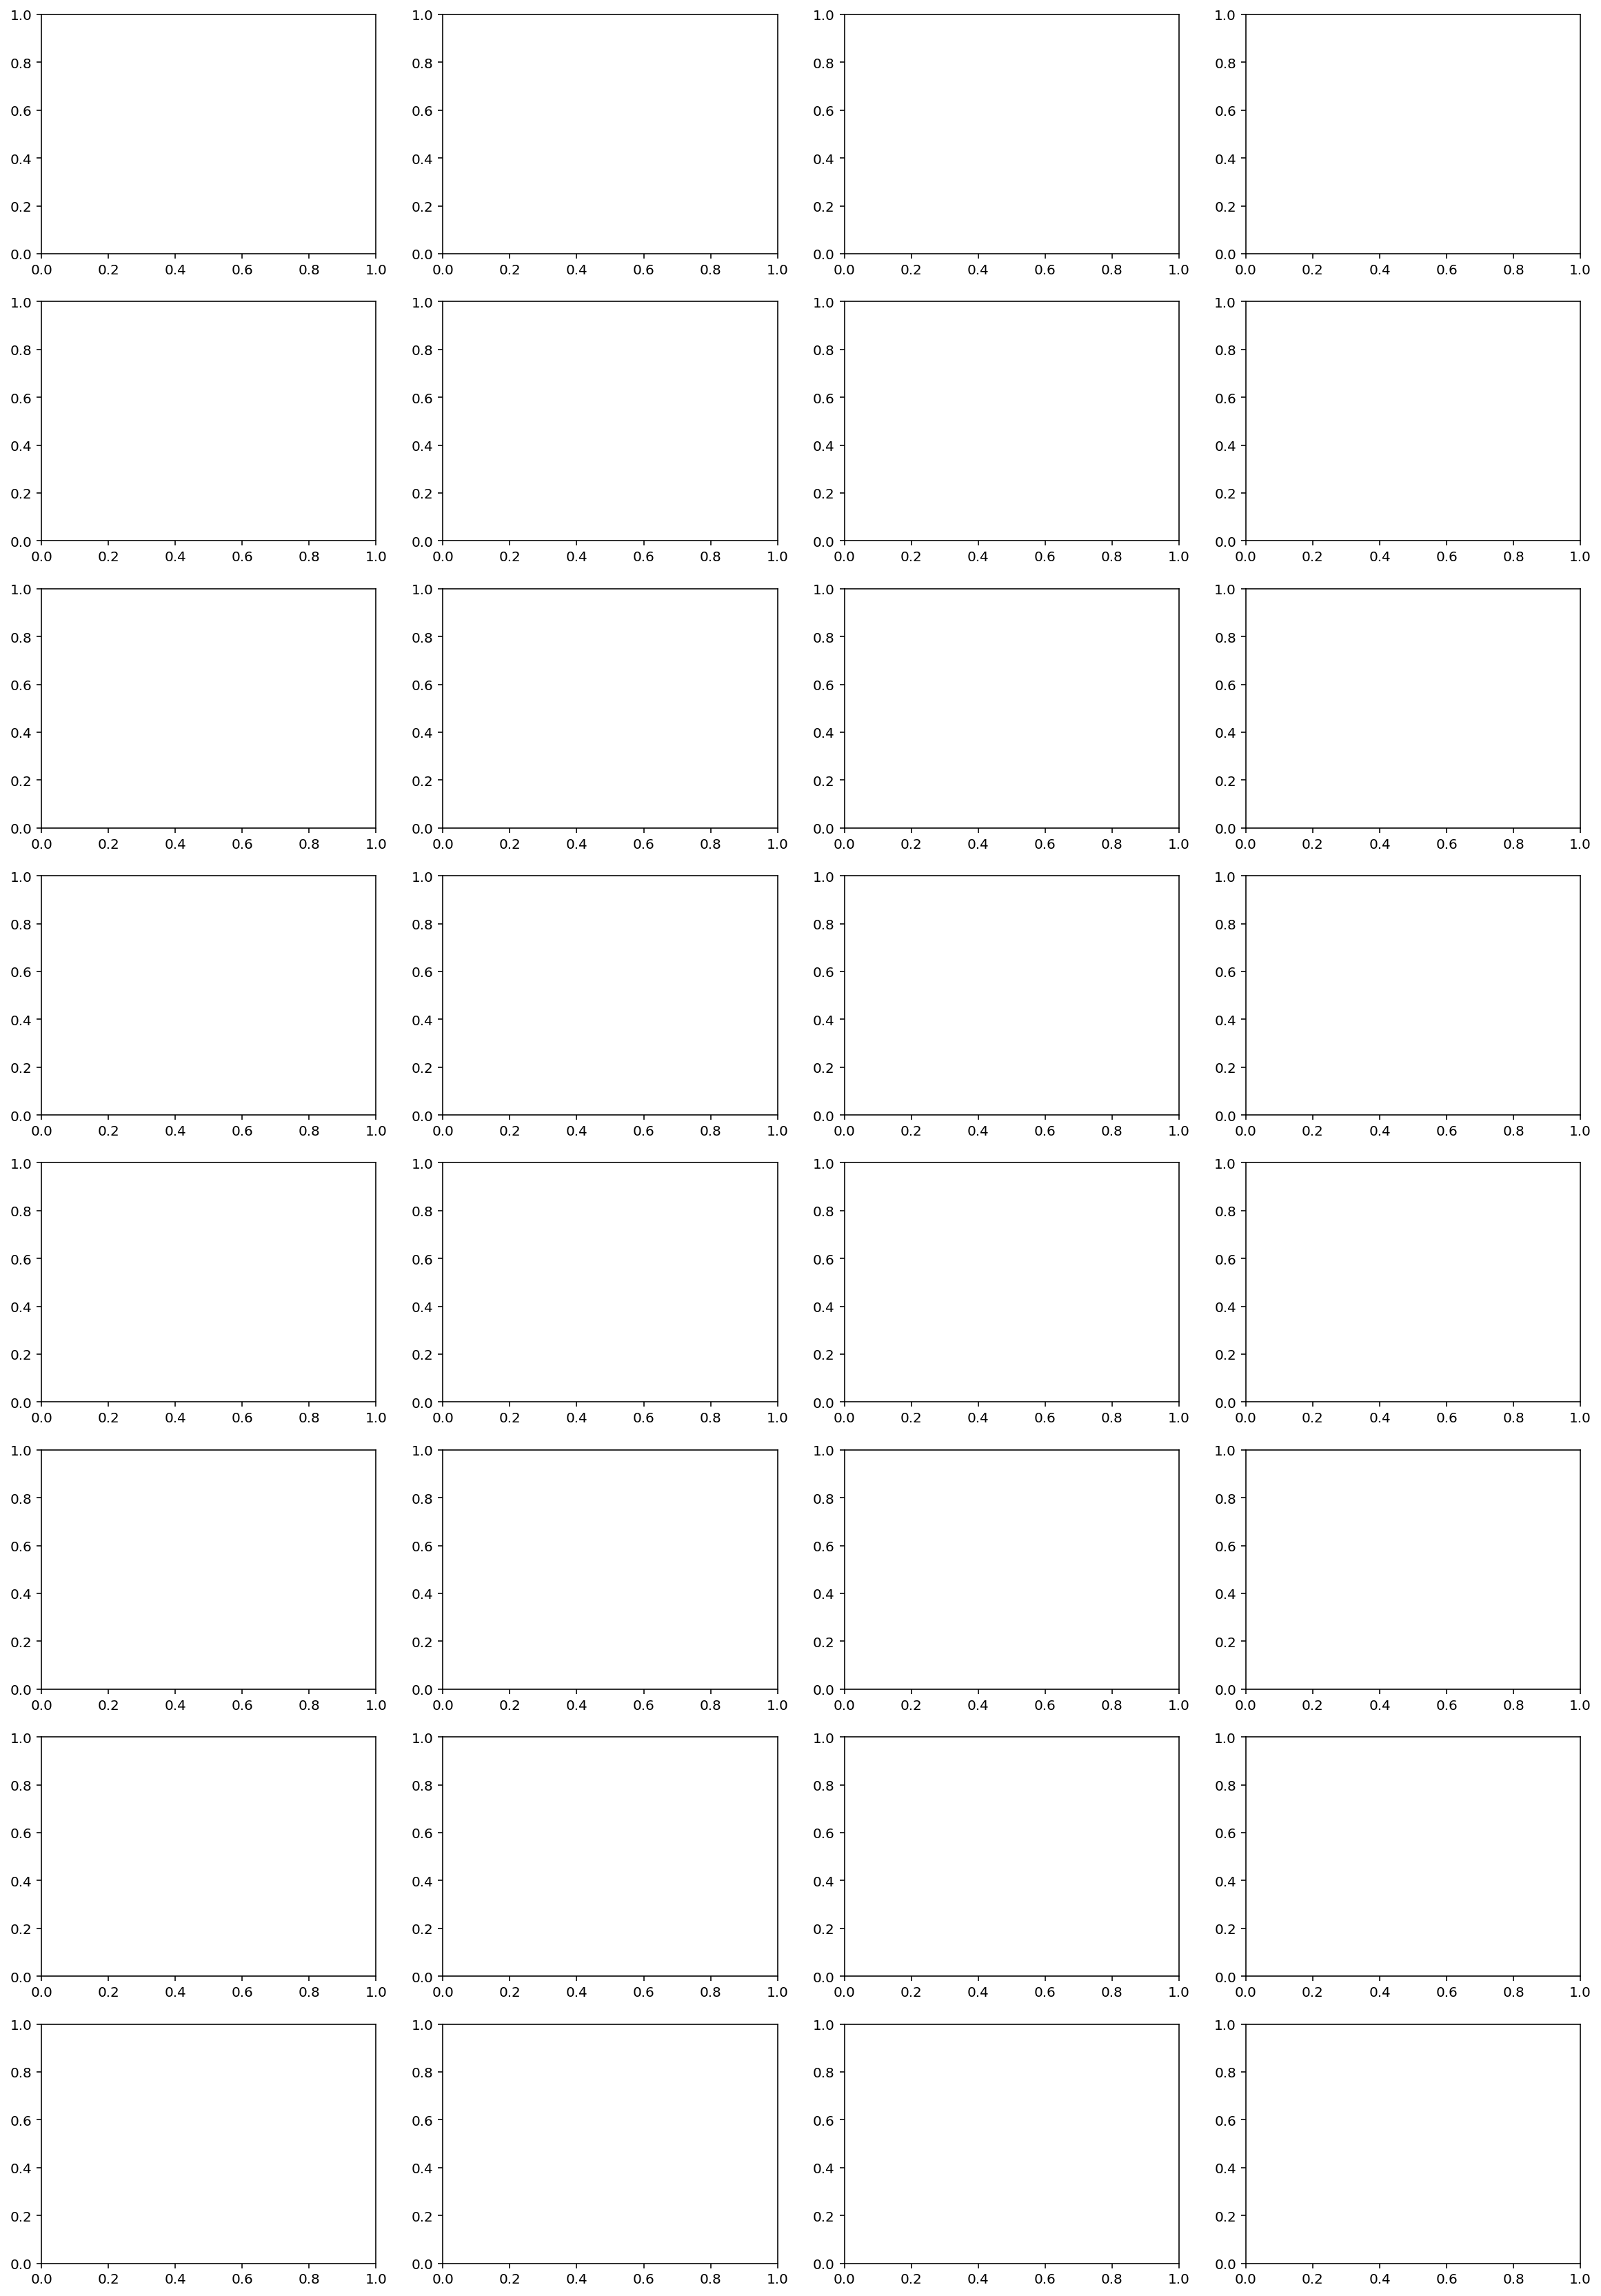

In [31]:
# Generate plot (may take a while as many individual maps are generated)
numPlotRows = 8
numPlotCols = 4
figWidth = 20 
figHeight = 30 
 
fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight))


### Discussion

**TK**

TK

**TK**

TK

#### References

This project uses code from several Pangeo CMIP Tutorials including: <br>
[Drake and Abernathey, Estimating Equilibrium Climate Sensitivity (ECS) in CMIP6 models](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/ECS_Gregory_method.html)